## Introduction

This notebook presents an implementation of a **sequence-to-sequence** (Seq2Seq) model using PyTorch. The model, built from scratch, leverages the **Transformer** architecture, a state-of-the-art model for sequence transduction tasks.

## Installing libraries

We begin with the installation of essential libraries. We'll be relying on the robust capabilities of **PyTorch**, **TorchText**, and **ANTLR4** to bring our transpiler to life.

In [2]:
!pip install torch 
!pip install torchtext==0.18.0
!pip install antlr4-python3-runtime==4.9.2


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Importing libraries

We then import all the necessary libraries. **json** will be used to import our data, **antlr4** provides the backbone for our transpiler, enabling us to parse PL/I code and manipulate its structure with ease, **torch** PyTorch empowers us to build and train neural networks seamlessly, **torchtext** complements PyTorch by providing utilities for text processing and dataset handling, **jinja2** simplifies code generation with its template engine ensuring a smooth transition between languages and to finish **matplotlib** will come in handy during training for visualising our progress  

In [3]:
import torchtext; torchtext.disable_torchtext_deprecation_warning()
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.transforms import ToTensor
import json
from antlr4 import *
from pli.PLILexer import PLILexer
from pli.PLIParser import PLIParser
from pli.PLIVisitor import PLIVisitor
from jinja2 import Template
import matplotlib.pyplot as plt

## The model

The Transformer class encapsulates a custom implementation of the Transformer model, a powerful architecture for **sequence-to-sequence** tasks. It comprises various components, including **embedding layers** for source and target sequences, **positional embeddings** to capture sequence order, and a multi-layer Transformer module. The model utilizes **dropout** for regularization and employs **masks** to handle padding and prevent information leakage during training. With these components, the Transformer class can efficiently process source and target sequences, facilitating tasks like language translation or code generation

In [4]:
class Transformer(nn.Module):

    # Initialises the Transformer model
    def __init__(
            self,
            embedding_size,
            src_vocab_size,
            trg_vocab_size,
            src_pad_idx,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
            max_len,
            device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    # Generates a mask for the source sequence to handle padding
    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    # Forward pass of the Transformer model
    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
                .unsqueeze(1)
                .expand(src_seq_length, N)
                .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
                .unsqueeze(1)
                .expand(trg_seq_length, N)
                .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(
            self.device
        )

        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out

## EDA

### Tokenize

We define a simple **tokenizer** that splits a string into tokens based on whitespace, it then creates two **Field** objects with some specifications and finally we create a dictionary that maps field names to tuples to be used later to specify how to load and process the data 

In [42]:
tokenizer = lambda x: x.split()

def yield_tokens(data_iter, text_field):
    for item in data_iter:
        yield tokenizer(item['translation'][text_field])

### Splits

We're using the TabularDataset module from the torchtext.data package to create separate datasets for **training** and **testing**. The data is loaded from JSON files located in the 'data' directory. We specify the format of the data as JSON and define the fields to be extracted from the JSON files using the fields parameter

### Vocab

Building a vocabulary involves creating a dictionary that maps each unique word in the dataset to a unique index. This process is crucial for natural language processing tasks as it allows machine learning models to represent words as numerical values, which they can process and understand. In this case, we're building vocabularies for the PL/I (pli) and Kotlin (ktl) datasets, ensuring that the model has a predefined set of words it can understand and process during training and inference.

In [24]:
def setup_vocab(data_file, text_field):
    with open(data_file, 'r') as f:
        data = json.load(f)
    vocab = build_vocab_from_iterator(yield_tokens(data['data'], text_field), specials=["<sos>", "<eos>", "<pad>", "<unk>"])
    vocab.set_default_index(vocab["<unk>"])
    return vocab
    
pli_vocab = setup_vocab('data/train1.json', 'pli')
ktl_vocab = setup_vocab('data/train1.json', 'ktl')

In [25]:
def data_process(raw_text_iter, src_vocab, trg_vocab):
    data = []
    for item in raw_text_iter['data']:
        src_tensor = torch.tensor([src_vocab[token] for token in tokenizer(item['translation']['pli'])], dtype=torch.long)
        trg_tensor = torch.tensor([trg_vocab[token] for token in tokenizer(item['translation']['ktl'])], dtype=torch.long)
        data.append((src_tensor, trg_tensor))
    return data

In [26]:
pli_vocab = setup_vocab('data/train1.json', 'pli')
ktl_vocab = setup_vocab('data/train1.json', 'ktl')

In [44]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for (_text, _label) in batch:
         # Assuming _text is already tensorized
         lengths.append(len(_text))
         label_list.append(torch.tensor(_label))
         text_list.append(_text)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)  # pad_value depends on your settings
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)

    return text_list, label_list, lengths

In [45]:
with open('data/train1.json', 'r') as f:
    raw_train_data = json.load(f)
train_data = data_process(raw_train_data, pli_vocab, ktl_vocab)
train_iter = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)

### Translate

We define a **translate_sequence** function. It tokenizes the input sentence, adds <SOS> and <EOS> tokens at the beginning and end respectively, converts the tokens to indices using the vocabulary of the pli field, converts the indices to a PyTorch tensor, and iteratively predicts the next token in the translated sequence using the trained model until either the <EOS> token is predicted or the maximum length is reached. Finally, it converts the predicted indices back to tokens using the vocabulary of the Kotlin field and returns the translated sentence, removing the start token <sos>

In [29]:
def translate_sequence(sentence, pli_vocab, ktl_vocab, device, max_length=50):
    if isinstance(sentence, str):
        tokens = [token.lower() for token in sentence.split()]
    else:
        tokens = [token.lower() for token in sentence]
    
    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, "<sos>")
    tokens.append("<eos>")

    # Retrieve the stoi mapping
    pli_stoi = pli_vocab.get_stoi()
    ktl_stoi = ktl_vocab.get_stoi()

    # Convert each language token to an index
    text_to_indices = [pli_stoi[token] if token in pli_stoi else pli_stoi["<unk>"] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    outputs = [ktl_stoi["<sos>"]]
    for i in range(max_length):
        trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)

        with torch.no_grad():
            output = model(sentence_tensor, trg_tensor)

        best_guess = output.argmax(2)[-1, :].item()
        outputs.append(best_guess)

        if best_guess == ktl_stoi["<eos>"]:
            break

    translated_sentence = [ktl_vocab.get_itos()[idx] for idx in outputs]
    # Remove start token
    return translated_sentence[1:]

### Transpile

We define a **transpile_sequence** function. It retrieves the code tokens and context data from the input dictionary. Then, it initializes an empty list to store the transpiled code with proper indentation. The function then iterates through the tokens, adjusting the indentation level based on curly braces {} encountered in the code. It ignores the <eos> token. And after iterating through all the tokens, the function joins the transpiled code with proper spacing and renders it using the contextual data. Finally, it returns the transpiled code and the updated indentation level.

In [30]:
def transpile_sequence(translated, level):
    tokens = translated["code"]
    data = translated["context"]
    lint = []

    for t in tokens:
        spacer = "".rjust(level * 4)
        if t == "{":
            level += 1
        elif t == "}" and level > 0:
            level -= 1
            spacer = "".rjust(level * 4)

        if t != "<eos>":
            lint.append(spacer + t)

    code = " ".join(lint)
    t = Template(code)

    return t.render(data), level

## Training

### Hyperparameters

We define some **model hyperparameters** that help define how our model processes and transforms our input data. We also define some **training hyperparameters** that regulate the training process of our model

In [38]:
global level
# Training hyperparameters
num_epochs = 150
learning_rate = 3e-4
batch_size = 32
training_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    factor=0.1, 
    patience=10, 
    verbose=True
)

pad_idx = ktl_vocab['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

load_model = True
save_model = True

# Model hyperparameters
src_vocab_size = len(pli_vocab.vocab)
trg_vocab_size = len(ktl_vocab.vocab)
embedding_size = 512
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.10
max_len = 100
forward_expansion = 4
src_pad_idx = ktl_vocab.get_stoi()["<pad>"]



### Specifics

This **remove_eos** function removes all "< eos >" tokens and then concatenate the remaining tokens into a single string

In [39]:
def remove_eos(witheos):
    noeos = []
    for w in witheos:
        if w != '<eos>':
            noeos.append(w)
    return " ".join(noeos)


These functions, **save_checkpoint** and **load_checkpoint**, are essential for saving and loading the state of a model during training or inference.

In [40]:
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

### Model Initialization and Training Setup

Here we **initialize** the model, optimizer, scheduler, and criterion for training a Transformer model. It also creates **iterators** for the training and test datasets.

In [48]:
from torch.utils.data import Dataset, DataLoader

In [49]:
class TranslationDataset(Dataset):
    def __init__(self, filename, src_vocab, trg_vocab, tokenizer):
        with open(filename, 'r') as file:
            data = json.load(file)['data']
        
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.tokenizer = tokenizer

        self.src_data = [self.encode(sentence['translation']['pli'], self.src_vocab) for sentence in data]
        self.trg_data = [self.encode(sentence['translation']['ktl'], self.trg_vocab) for sentence in data]

    def encode(self, text, vocab):
        return [vocab[token] if token in vocab else vocab['<unk>'] for token in self.tokenizer(text)]

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return self.src_data[idx], self.trg_data[idx]

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_batch = pad_sequence([torch.tensor(data) for data in src_batch], padding_value=src_pad_idx, batch_first=True)
    trg_batch = pad_sequence([torch.tensor(data) for data in trg_batch], padding_value=trg_pad_idx, batch_first=True)
    return src_batch, trg_batch

In [52]:
train_dataset = TranslationDataset('data/train1.json', pli_vocab, ktl_vocab, tokenizer)
test_dataset = TranslationDataset('data/train1.json', pli_vocab, ktl_vocab, tokenizer)

In [53]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
train_iterator, test_iterator = BucketIterator.splits(
    (train, test),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.p),
    device=device,
)

### Training loop

Within the training loop, batches of data are fetched using the **training_iterator**. Input and target sequences are transferred to the appropriate device (CPU or GPU), and the model is then trained using **forward** and **backward** passes. **Gradient clipping** is applied to prevent exploding gradients, and the **optimizer** is used to update the model parameters based on the computed gradients. After training, we evaluate the model's performance on example pli sequences, translating them to Kotlin using the trained model. Finally we utilise matplotlib to visualize the training loss over iterations and optionally save the trained model checkpoint for future use.

In [55]:
src_pad_idx = pli_vocab['<pad>']
trg_pad_idx = ktl_vocab['<pad>']

[Epoch 0 / 150]
Translated example sentence:
                                                 
  ( ( ( (  ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( (
  ( ( ( (  ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( (
Last 5 training losses: []
[Epoch 0 / 150] Mean Loss: 3.312333822250366
Recent training losses: [3.312333822250366]
[Epoch 1 / 150] Mean Loss: 2.570452928543091
[Epoch 2 / 150] Mean Loss: 1.6449109315872192
[Epoch 3 / 150] Mean Loss: 1.8648922443389893
[Epoch 4 / 150] Mean Loss: 1.6432406902313232
[Epoch 5 / 150] Mean Loss: 1.3321876525878906
[Epoch 6 / 150] Mean Loss: 1.2660270929336548
[Epoch 7 / 150] Mean Loss: 1.1929463148117065
[Epoch 8 / 150] Mean Loss: 1.0591377019882202
[Epoch 9 / 150] Mean Loss: 1.0396826267242432
[Epoch 10 / 150] Mean Loss: 1.0811278820037842
Recent training losses: [1.2660270929336548, 1.1929463148117065, 1.0591377019882202, 1.0396826267242432, 1.0811278820037842]
[Epoch 11 

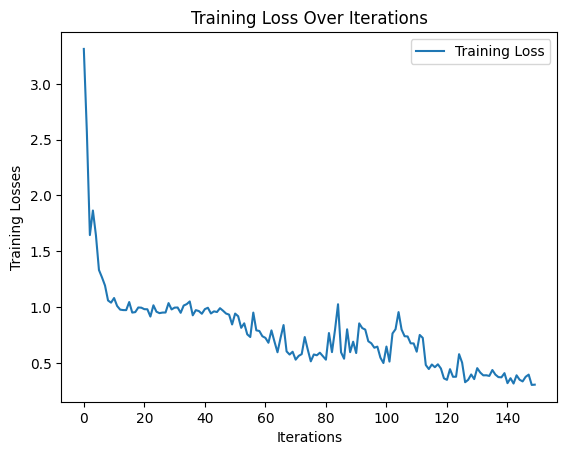

In [57]:
if __name__ == '__main__':
    for epoch in range(num_epochs):
        # Evaluation phase
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient computation
            if epoch % 50 == 0:
                print(f"[Epoch {epoch} / {num_epochs}]")
                # Example sentences for demonstration
                sentences = [
                    {'pli': ['PROCEDURE', 'MAIN', '{{type0}}', '{{type1}}'], 'context': {'type0': 'Array', 'type1': 'String'}},
                    {'pli': ['DO'], 'context': {}},
                    {'pli': ['END'], 'context': {}}
                ]
                print("Translated example sentence:")
                level = 0
                for s in sentences:
                    translated = translate_sequence(
                        s['pli'], pli_vocab, ktl_vocab, device, max_length=50
                    )
                    transpiled, level = transpile_sequence({
                        'code': translated,
                        'context': s['context']
                    }, level)
                    print(transpiled)
                last_5_losses = training_losses[-5:]
                print("Last 5 training losses:", last_5_losses)

        # Training phase
        model.train()  # Set the model to training mode
        losses = []
        for batch_idx, (src_batch, trg_batch) in enumerate(train_loader):
            src_batch, trg_batch = src_batch.to(device), trg_batch.to(device)  # Move data to the device

            # Forward pass
            output = model(src_batch, trg_batch[:, :-1])  # Target offset by one for 'teacher forcing'
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg_batch = trg_batch[:, 1:].contiguous().view(-1)

            # Calculate loss
            optimizer.zero_grad()  # Clear gradients
            loss = criterion(output, trg_batch)  # Compute the loss
            losses.append(loss.item())

            # Backward pass and optimize
            loss.backward()  # Backpropagation
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Gradient clipping
            optimizer.step()  # Update parameters

            # Store the loss
            training_losses.append(loss.item())

        # Average loss for the epoch
        mean_loss = sum(losses) / len(losses)
        scheduler.step(mean_loss)  # Update learning rate schedule

        # Print training summary for the epoch
        print(f"[Epoch {epoch} / {num_epochs}] Mean Loss: {mean_loss}")
        if epoch % 10 == 0:  # Optionally print more frequently
            print("Recent training losses:", training_losses[-5:])

    # Post training: review and save
    print("Final Epoch:", f"[Epoch {num_epochs} / {num_epochs}]")
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

    # Plot the training loss
    plt.plot(training_losses, label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Training Losses')
    plt.title('Training Loss Over Iterations')
    plt.legend()
    plt.show()

[Epoch 0 / 150]
Translated example sentence:
<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Last 5 training losses: [0.33403563499450684, 0.3755839

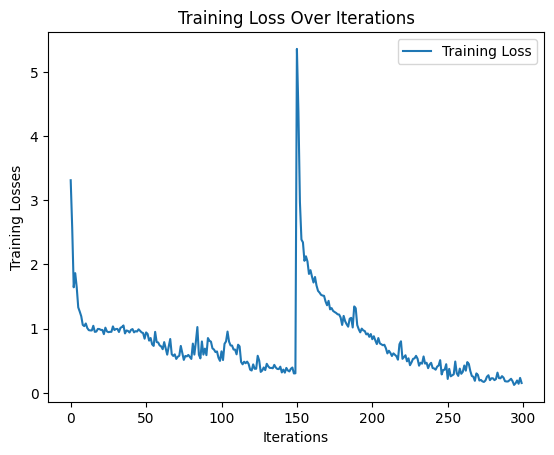

=> Saving checkpoint


In [70]:
if __name__ == '__main__':
    for epoch in range(num_epochs):
        model.eval()
        if epoch % 50 == 0:
            print(f"[Epoch {epoch} / {num_epochs}]")
            sentences = [
                {'pli': ['PROCEDURE', 'MAIN', '{{type0}}', '{{type1}}'], 'context': {'type0': 'Array', 'type1': 'String'}},
                {'pli': ['DO'], 'context': {}},
                {'pli': ['END'], 'context': {}}
            ]
            print("Translated example sentence:")
            level = 0
            for s in sentences:
                translated = translate_sequence(
                    s['pli'], pli_vocab, ktl_vocab, device, max_length=50
                )
                transpiled, level = transpile_sequence({
                    'code': translated,
                    'context': s['context']
                }, level)
                print(transpiled)
            last_5_losses = training_losses[-5:]
            print("Last 5 training losses:", last_5_losses)

        model.train()
        losses = []
        for batch_idx, batch in enumerate(train_iter):
            inp_data = batch[0].to(device)
            target = batch[1].to(device)

            output = model(inp_data, target[:-1, :])
            output = output.reshape(-1, output.shape[2])
            target = target[1:].reshape(-1)

            optimizer.zero_grad()
            loss = criterion(output, target)
            losses.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            training_losses.append(loss.item())

        mean_loss = sum(losses) / len(losses)
        scheduler.step(mean_loss)

    print(f"[Epoch {num_epochs} / {num_epochs}]")
    for s in sentences:
        translated = translate_sequence(
            s['pli'], pli_vocab, ktl_vocab, device, max_length=50
        )
        transpiled, level = transpile_sequence({
            'code': translated,
            'context': s['context']
        }, level)
        print(transpiled)

    last_5_losses = training_losses[-5:]
    print("Last 5 training losses:", last_5_losses)

    plt.plot(training_losses, label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Training Losses')
    plt.title('Training Loss Over Iterations')
    plt.legend()
    plt.show()

    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

### Running the model 

Finally, to show how our transpiller works, we define a **run_model** function where we're processing a PL1 file, which contains original PL1 code. First, we load our pre-trained model and its optimizer using the checkpoint file. Then, we set up a lexer and parser for the PL1 code using ANTLR4. We generate a dataset from the parsed code using a visitor pattern, which iterates through the AST (Abstract Syntax Tree) generated by the parser. For each statement in the PL1 code, we translate it into Kotlin using our sequence-to-sequence model and transpile it into Kotlin code. The transpiled Kotlin code is accumulated and printed as the output. This function essentially automates the process of translating our PL1 code to Kotlin

In [58]:
def run_model(filename):

    with open(filename, 'r') as file:
        original_code = file.read()
    print("PL1:")
    print(original_code)
    print()

    load_checkpoint(torch.load("checkpoint.pth.tar"), model, optimizer)
    # Lexer setup
    input_stream = FileStream(filename)
    lexer = PLILexer(input_stream)
    stream = CommonTokenStream(lexer)

    # Parser setup
    parser = PLIParser(stream)
    tree = parser.program()

    # Dataset generation
    visitor = PLIVisitor()
    statements = visitor.visit(tree)

    # Accumulate transpiled sequences
    transpiled_code = ""
    level = 0
    for s in statements:
        translated = translate_sequence(
            s["pli"], pli_vocab, ktl_vocab, device, max_length=50
        )
        transpiled, level = transpile_sequence({
            'code': translated,
            'context': s['context']
        }, level)
        transpiled_code += transpiled+ "\n"

    # Print the entire block of transpiled code
    print("KTL:")
    print("\n" + transpiled_code)

# Example usage:
run_model("FIB.PLI")

PL1:

 Factorial: proc options (main);
    dcl (n,result) fixed bin(31);
    n  = 5;
    result = Compute_factorial(n);

 end Factorial;
  /***********************************************/
  /* Subroutine                                  */
  /***********************************************/
  Compute_factorial: proc (n)  returns (fixed bin(31));
     dcl n fixed bin(15);
      if n <= 1 then
        return(1);

     return( n*Compute_factorial(n-1) );

  end Compute_factorial;


=> Loading checkpoint
KTL:

<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <